In [6]:
import pandas as pd
import numpy as np
import pickle
from keras.datasets import mnist
import matplotlib.pyplot as plt

2022-11-03 20:13:24.427396: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-03 20:13:24.955750: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-03 20:13:26.205242: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib/python3.8/site-packages/torch/lib:/opt/conda/lib/python3.8/site-packages/torch_tensorrt/lib:/usr/local/cuda/compat/lib:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
2022-11-03 20:13:26.205393: W te

In [13]:
def ReLU(Z):
    return np.maximum(Z,0)

def derivative_ReLU(Z):
    return Z > 0

def softmax(Z):
    """Compute softmax values for each sets of scores in x."""
    exp = np.exp(Z - np.max(Z))
    return exp / exp.sum(axis=0)

def init_params(size):
    W1 = np.random.normal(size=(10, size)) * np.sqrt(1./(size))
    b1 = np.random.normal(size=(10, 1)) * np.sqrt(1./10)
    W2 = np.random.normal(size=(10, 10)) * np.sqrt(1./20)
    b2 = np.random.normal(size=(10, 1)) * np.sqrt(1./(784))
    return W1,b1,W2,b2

def forward_propagation(X,W1,b1,W2,b2):
    Z1 = W1.dot(X) + b1 #10, m
    A1 = ReLU(Z1) # 10,m
    Z2 = W2.dot(A1) + b2 #10,m
    A2 = softmax(Z2) #10,m
    return Z1, A1, Z2, A2

def one_hot(Y):
    ''' return an 0 vector with 1 only in the position correspondind to the value in Y'''
    one_hot_Y = np.zeros((Y.max()+1,Y.size))
    one_hot_Y[Y,np.arange(Y.size)] = 1
    return one_hot_Y

def backward_propagation(X, Y, A1, A2, W2, Z1, m):
    one_hot_Y = one_hot(Y)
    dZ2 = 2*(A2 - one_hot_Y) #10, m
    dW2 = 1/m * (dZ2.dot(A1.T)) # 10, 10
    db2 = 1/m * np.sum(dZ2,1) # 10, 1
    dZ1 = W2.T.dot(dZ2)*derivative_ReLU(Z1) # 10, m
    dW1 = 1/m * (dZ1.dot(X.T)) #10, 784
    db1 = 1/m * np.sum(dZ1,1) # 10, 1

    return dW1, db1, dW2, db2

def update_params(alpha, W1, b1, W2, b2, dW1, db1, dW2, db2):
    W1 -= alpha * dW1
    b1 -= alpha * np.reshape(db1, (10,1))
    W2 -= alpha * dW2
    b2 -= alpha * np.reshape(db2, (10,1))

    return W1, b1, W2, b2

def get_predictions(A2):
    return np.argmax(A2, 0)

def get_accuracy(predictions, Y):
    return np.sum(predictions == Y)/Y.size

def gradient_descent(X, Y, alpha, iterations):
    size , m = X.shape

    W1, b1, W2, b2 = init_params(size)
    for i in range(iterations):
        Z1, A1, Z2, A2 = forward_propagation(X, W1, b1, W2, b2)
        dW1, db1, dW2, db2 = backward_propagation(X, Y, A1, A2, W2, Z1, m)

        W1, b1, W2, b2 = update_params(alpha, W1, b1, W2, b2, dW1, db1, dW2, db2)   

        if (i+1) % int(iterations/10) == 0:
            print(f"Iteration: {i+1} / {iterations}")
            prediction = get_predictions(A2)
            print(f'{get_accuracy(prediction, Y):.3%}')
            
    return W1, b1, W2, b2

def make_predictions(X, W1 ,b1, W2, b2):
    _, _, _, A2 = forward_propagation(X, W1, b1, W2, b2)
    predictions = get_predictions(A2)
    return predictions

def show_prediction(index,X, Y, W1, b1, W2, b2):
    vect_X = X[:, index,None]
    prediction = make_predictions(vect_X, W1, b1, W2, b2)
    label = Y[index]
    print("Prediction: ", prediction)
    print("Label: ", label)

    current_image = vect_X.reshape((WIDTH, HEIGHT)) * SCALE_FACTOR

    plt.gray()
    plt.imshow(current_image, interpolation='nearest')
    plt.show()

Iteration: 20 / 200
74.000%
Iteration: 40 / 200
81.942%
Iteration: 60 / 200
84.857%
Iteration: 80 / 200
87.582%
Iteration: 100 / 200
88.807%
Iteration: 120 / 200
89.390%
Iteration: 140 / 200
89.773%
Iteration: 160 / 200
90.115%
Iteration: 180 / 200
90.352%
Iteration: 200 / 200
90.615%
Prediction:  [7]
Label:  7


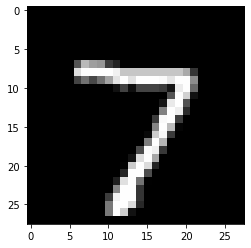

Prediction:  [2]
Label:  2


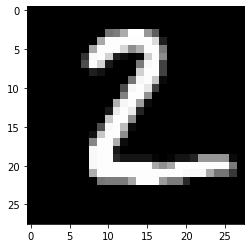

Prediction:  [1]
Label:  1


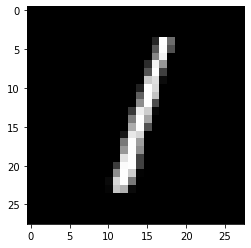

Prediction:  [6]
Label:  6


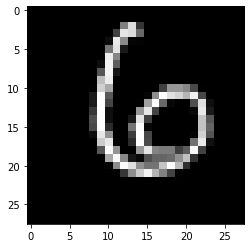

Prediction:  [3]
Label:  3


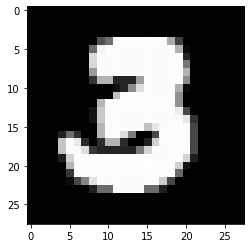

In [15]:
############## MAIN ##############

(X_train, Y_train), (X_test, Y_test) = mnist.load_data()
SCALE_FACTOR = 255
WIDTH = X_train.shape[1]
HEIGHT = X_train.shape[2]
X_train = X_train.reshape(X_train.shape[0],WIDTH*HEIGHT).T / SCALE_FACTOR
X_test = X_test.reshape(X_test.shape[0],WIDTH*HEIGHT).T  / SCALE_FACTOR

W1, b1, W2, b2 = gradient_descent(X_train, Y_train, 0.15, 200)
with open("trained_params.pkl","wb") as dump_file:
    pickle.dump((W1, b1, W2, b2),dump_file)

with open("trained_params.pkl","rb") as dump_file:
    W1, b1, W2, b2=pickle.load(dump_file)
show_prediction(0,X_test, Y_test, W1, b1, W2, b2)
show_prediction(1,X_test, Y_test, W1, b1, W2, b2)
show_prediction(2,X_test, Y_test, W1, b1, W2, b2)
show_prediction(100,X_test, Y_test, W1, b1, W2, b2)
show_prediction(200,X_test, Y_test, W1, b1, W2, b2)